### Imports and functions

In [1]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# imports
import json, time, random
import os.path, urllib
from io import StringIO
from urllib.request import urlopen
from datetime import datetime, date

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error

import boto3
from basic_utils import *

Loading config.json


In [2]:
# format / clean up functions
def clean_up_fmt(df):
    fmt_cols = [x for x in df.columns.tolist() if str.lower(x).find('fmt') > 0]
    raw_cols = [x for x in df.columns.tolist() if str.lower(x).find('raw') > 0]
    rndm_map = { x: x[:x.index('.')] for x in raw_cols }
    df.drop(fmt_cols, axis=1, inplace=True)
    df.rename(rndm_map, axis=1, inplace=True)
    return df
def cols_to_date(df, cols):
    for c in cols: 
        if c in df.columns:
            df[c] = df[c].apply(date_lambda)
def cols_to_bool(df, cols):
    for c in cols: df[c] = df[c].apply(lambda x: pd.to_numeric(x))
def divide_by(df, cols, tgt):
    cols.extend([tgt])
    res = (df[cols].T / df[cols][tgt]).T
    cols.remove(tgt)
    return res[cols]

# lambdas
date_lambda = lambda x: date.fromtimestamp(x)
pd_datetime = lambda x: pd.to_datetime(x)
# date_lambda = lambda x: date.fromtimestamp(x) if x > 0 else 0
datetime_lambda = lambda x: datetime.fromtimestamp(x) if x > 0 else 0
time_delta_to_years = lambda x: x / 365
divide_by_mean = lambda x: x / x.median() #consider z-score
cap_at_1q = lambda x: [max(y, 0) for y in x]
z_score = lambda x: (x - x.mean()) / x.std()

In [187]:
# transforms and utilities
def merge_ds(fs_df, q_df):
    # data type conversions
    date_cols = ['regularMarketTime', 'earningsTimestamp',
        'earningsTimestampStart','expiration','lastTradeDate']
    fs_df = fs_df.fillna(0)
    q_df = q_df.fillna(0)
    cols_to_date(fs_df, date_cols)
    cols_to_date(q_df, date_cols)
    
    # merge options and quotes
    merged_df = q_df.merge(fs_df, how='inner', 
                           left_on=['symbol', 'regularMarketTime'], 
                           right_on=['underlyingSymbol','lastTradeDate'])
    return merged_df
def transform_ds(df):
    # consider passing common fields as a map (divide by, divide col, etc)
    mod_df = df.copy()
    
    # transformation: divide by closing price (unit values to underlying price)
    divide_cols = ['lastPrice', 'strike', 'epsForward', 'epsTrailingTwelveMonths',
        'bookValue', 'regularMarketDayHigh',
        'regularMarketDayLow', 'regularMarketOpen', 'regularMarketPreviousClose']
    divided_by = 'regularMarketPrice'
    mod_df[divide_cols] = divide_by(mod_df, divide_cols, divided_by).round(4)
    mod_df.regularMarketVolume = divide_by(
        mod_df, ['regularMarketVolume'], 'averageDailyVolume10Day').round(4)

    # transformation: volume (liquidity) and size relative to the universe mean
    scale_cols = ['regularMarketVolume','averageDailyVolume10Day',
                  'averageDailyVolume3Month','marketCap']
    scaler_pipe = make_pipeline(StandardScaler())
    mod_df[scale_cols] = scaler_pipe.fit_transform(mod_df[scale_cols])
    
    # transformation: turn dates > days > years
    
#     cols_to_date(mod_df, ['storeDate'])
    mod_df.regularMarketTime = pd.to_datetime(mod_df.regularMarketTime)
    mod_df.expiration = pd.to_datetime(mod_df.expiration)
    delta = (mod_df.expiration - mod_df.regularMarketTime).dt.days
    mod_df.expiration = delta.apply(time_delta_to_years).round(4)

    return mod_df

def top_bottom_selection(df, key, sortKey, items):
    ranked_ret = df[[key,sortKey]].sort_values(by=sortKey)
    keyList = ranked_ret[key].head(items).tolist() + ranked_ret[key].tail(items).tolist()
    return df[df[key].isin(keyList)]

def filter_ds(df):    
    # filter data by expiration, strike, liquidity and active contracts
    oi_mask = df.openInterest > 100
    vol_mask = df.volume > 10
    itm_mask = (df.inTheMoney == False) & (
        ((df.strike > 0.8) & (df.strike < 0.95)) |
        ((df.strike > 1.05) & (df.strike < 1.2))
    )
    exp_mask = (df.expiration > 90/365)
    return df[oi_mask & vol_mask & itm_mask & exp_mask]

def prepare_for_training(df, cols_to_keep, y_col):    
    num_cols = df[cols_to_keep].select_dtypes(include=['float64'])
    order_cols = [x for x in num_cols if x != y_col]
    order_cols.extend([y_col])
    return df[order_cols]
def visualize_ds(df, bins=20, figsize=(20,20)):
    df.hist(figsize=figsize, bins=bins);    
def shuffle_train_test(df):
    df_idx = df.index.values
    df_idx = np.random.randint(0, len(df_idx), size=len(df_idx))
    shuffled_df = df.iloc[df_idx]
    train_df, test_df = train_test_split(shuffled_df, random_state=1)
    return train_df, test_df

In [156]:
# subset of columns we want to retain
# quote columns
to_keep = ['regularMarketTime', 'regularMarketVolume', 
    'epsForward', 'epsTrailingTwelveMonths', 'regularMarketDayHigh', 
    'regularMarketDayLow', 'regularMarketOpen', 'regularMarketPreviousClose', 
    'averageDailyVolume10Day', 'averageDailyVolume3Month', 'marketCap',
    'bookValue', 'fiftyDayAverageChangePercent', 'fiftyTwoWeekHighChangePercent',
    'fiftyTwoWeekLowChangePercent', 'trailingAnnualDividendYield',
    'twoHundredDayAverageChangePercent']
# option columns
to_keep.extend(['underlyingSymbol', 'type', 
           'expiration','impliedVolatility', 'lastPrice', 
           'strike','contractSymbol']) 
target_col = 'lastPrice'

In [202]:
# prediction and analysis functions
def update_deltas(ml_df, predictions, pred_col, var_col):
    post_pred_df = ml_df.copy()
    post_pred_df.loc[:,pred_col] = predictions
    post_pred_df.loc[:,var_col] = post_pred_df[pred_col] - post_pred_df.lastPrice
    return post_pred_df

def plot_deltas(post_pred_df, pred_col, var_col):
    fig = plt.figure(figsize=(10,10), dpi=300)
    ax1 = post_pred_df.plot.scatter(x='lastPrice', y=pred_col, 
        s=post_pred_df[var_col]*100, alpha=0.5, c='impliedVolatility', 
        cmap=plt.get_cmap('jet'),
        title='Predicted vs. Actual (bubble size=variance)')
    plt.setp(ax1.get_xticklabels(), visible=True)
#     ax1.set_xlim(0,.15)
#     ax1.set_ylim(0,.15)
    ax2 = post_pred_df.plot.scatter(
        x='strike', y='expiration', s=post_pred_df[var_col]*100, alpha=0.5, 
        c='impliedVolatility', cmap=plt.get_cmap('jet'),
        title='Expiration vs. Strikes (bubble size=variance)', sharex=ax1)
    plt.setp(ax2.get_xticklabels(), visible=True)
    plt.setp(ax2.get_xticklabels(), visible=True)
    plt.show()
    
rows_left = lambda x, y: print('{} left after {}'.format(len(x), y))
rows_left_by_type = lambda x, y, z: print('{}: {} calls, {} puts'.format(len(x), len(y), len(z)))

### Prediction using Local Model

In [6]:
# Date ranges for analysis
dates = read_dates('option')
predict_days = -1
predict_dates, train_dates = dates[predict_days:], dates[:predict_days]
train_dates, predict_dates
today_date = date.today()

In [192]:
# load contracts for predict date
pred_quote_frame = load_consol_quotes(predict_dates)
pred_full_set = load_consol_options(predict_dates)

# load the prediction date data
print('{} options {} quotes'.format(
    pred_full_set.underlyingSymbol.count(), 
    pred_quote_frame.symbol.count()))

# merge, filter and transform
pred_all_df = merge_ds(pred_full_set, pred_quote_frame)
rows_left(pred_all_df, 'merge')
pred_all_df = transform_ds(pred_all_df)
rows_left(pred_all_df, 'transform')
pred_all_df = filter_ds(pred_all_df)
rows_left(pred_all_df, 'filter')
pred_all_df = top_bottom_selection(pred_all_df, 'symbol', 'fiftyTwoWeekLowChangePercent', 25)
rows_left(pred_all_df, '2nd filter')

Loading quotes for 2018-09-25
Loading options for 2018-09-25
88625 options 325 quotes
32563 left after merge
32563 left after transform
841 left after filter
65 left after 2nd filter


In [193]:
ANALYSIS_COLS = ['contractSymbol', 'type' ,'underlyingSymbol',
                 'regularMarketPrice', 'impliedVolatility', 'expiration', 
                 'strike','lastPrice','prediction', 'predictionDelta']

In [209]:
option_types = ['call', 'put']
recommendations = pd.DataFrame()
post_pred_df = pd.DataFrame()

PREDICTION_COL = 'prediction'
DELTA_COL = 'predictionDelta'

pricingCols = ['lastPrice','prediction','predictionDelta']
adjUpsideCol = 'adjustedUpside'
recommendationDateCol = 'recommendationDate'

ANALYSIS_COLS = ['contractSymbol', 'type' ,'underlyingSymbol',
                 'regularMarketPrice', 'impliedVolatility', 'expiration', 
                 'strike','lastPrice','prediction', 'predictionDelta', 
                 adjUpsideCol, recommendationDateCol]

for OPTION_TYPE in option_types:

    ml_df = pred_all_df[pred_all_df.type == OPTION_TYPE]
    ml_train_df = prepare_for_training(ml_df, to_keep, target_col)
    rows_left(ml_train_df, OPTION_TYPE)

    X = ml_train_df.loc[:,ml_train_df.columns[:-1]].values
    Y = ml_train_df.loc[:,target_col].values

    fname = "{}_ML_model.pkl".format(OPTION_TYPE)
    model = joblib.load(fname)
    res = model.predict(X)

    print('Predicted {} RMSE {}'.format(OPTION_TYPE, np.sqrt(mean_squared_error(Y, res))))

    post_pred_df = update_deltas(ml_df, res, PREDICTION_COL, DELTA_COL)
    post_pred_df[pricingCols] = (
        post_pred_df[pricingCols].T * \
        pred_all_df.loc[post_pred_df.index].regularMarketPrice).T
    
    ajdustedUpside = (post_pred_df.predictionDelta / post_pred_df.lastPrice) * \
        post_pred_df.expiration * (1 - (1 - post_pred_df.strike).abs())

    post_pred_df[adjUpsideCol] = ajdustedUpside
    post_pred_df[recommendationDateCol] = str(today_date)
    
    final = post_pred_df[ANALYSIS_COLS]
    recommendations = recommendations.append(final)

recommendations = recommendations.sort_values(by=adjUpsideCol, ascending=False).head(12).round(3)
path = get_path('option_recomendation')
csv_store(recommendations, path, csv_ext.format('options-' + str(today_date)), True)
recommendations

36 left after call
Predicted call RMSE 0.04727917186273181
29 left after put
Predicted put RMSE 0.028287654192606076
Saved recommend/options/options-2018-09-26.csv


,contractSymbol,type,underlyingSymbol,regularMarketPrice,impliedVolatility,expiration,strike,lastPrice,prediction,predictionDelta,adjustedUpside,recommendationDate
6281,GM200117C00040000,call,GM,33.55,0.254,1.310,1.192,1.761,2.107,0.346,0.208,2018-09-26
6418,GM190315P00027000,put,GM,33.55,0.306,0.466,0.805,0.460,0.625,0.166,0.135,2018-09-26
27004,GE200117P00010000,put,GE,11.27,0.304,1.310,0.887,0.920,1.022,0.102,0.129,2018-09-26
6245,GM190118C00039000,call,GM,33.55,0.250,0.312,1.162,0.369,0.547,0.178,0.126,2018-09-26
6266,GM190315C00038000,call,GM,33.55,0.250,0.466,1.133,0.819,1.043,0.224,0.111,2018-09-26
26969,GE190118P00010000,put,GE,11.27,0.326,0.312,0.887,0.290,0.402,0.112,0.107,2018-09-26
6267,GM190315C00039000,call,GM,33.55,0.252,0.466,1.162,0.651,0.817,0.166,0.100,2018-09-26
6280,GM200117C00038000,call,GM,33.55,0.255,1.310,1.133,2.241,2.420,0.179,0.091,2018-09-26
26983,GE190315P00010000,put,GE,11.27,0.317,0.466,0.887,0.420,0.499,0.079,0.077,2018-09-26
6404,GM190118P00029000,put,GM,33.55,0.286,0.312,0.864,0.450,0.552,0.103,0.062,2018-09-26


### Sanity Checks

In [205]:
recommendations.head(12)

,contractSymbol,type,underlyingSymbol,regularMarketPrice,impliedVolatility,expiration,strike,lastPrice,prediction,predictionDelta,adjustedUpside,recommendationDate
6281,GM200117C00040000,call,GM,33.55,0.254,1.310,1.192,1.761,2.107,0.346,0.208,2018-09-26
6418,GM190315P00027000,put,GM,33.55,0.306,0.466,0.805,0.460,0.625,0.166,0.135,2018-09-26
27004,GE200117P00010000,put,GE,11.27,0.304,1.310,0.887,0.920,1.022,0.102,0.129,2018-09-26
6245,GM190118C00039000,call,GM,33.55,0.250,0.312,1.162,0.369,0.547,0.178,0.126,2018-09-26
6266,GM190315C00038000,call,GM,33.55,0.250,0.466,1.133,0.819,1.043,0.224,0.111,2018-09-26
26969,GE190118P00010000,put,GE,11.27,0.326,0.312,0.887,0.290,0.402,0.112,0.107,2018-09-26
6267,GM190315C00039000,call,GM,33.55,0.252,0.466,1.162,0.651,0.817,0.166,0.100,2018-09-26
6280,GM200117C00038000,call,GM,33.55,0.255,1.310,1.133,2.241,2.420,0.179,0.091,2018-09-26
26983,GE190315P00010000,put,GE,11.27,0.317,0.466,0.887,0.420,0.499,0.079,0.077,2018-09-26
6404,GM190118P00029000,put,GM,33.55,0.286,0.312,0.864,0.450,0.552,0.103,0.062,2018-09-26


In [203]:
lessDetailCol = ['contractSymbol',
 'type',
 'impliedVolatility',
 'expiration',
 'strike',
 'lastPrice',
 'prediction',
 'predictionDelta',
 'expHedgedReturn']

/Users/vveiga/miniconda3/lib/python3.6/site-packages/matplotlib/collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<Figure size 3000x3000 with 0 Axes>

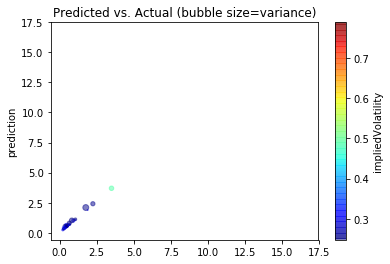

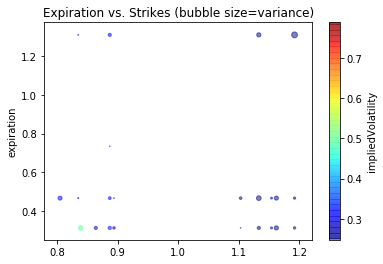

In [204]:
plot_deltas(recommendations, PREDICTION_COL, DELTA_COL)

In [119]:
# test_df = recommendations[lessDetailCol].sort_values(by=expHedgedReturnCol, ascending=False).copy()
# test_df['expHedgedReturn'] = test_df.predictionDelta / test_df.lastPrice
# test_df['riskScore'] = test_df.expiration * (1 - (1 - test_df.strike).abs()) * test_df.expHedgedReturn
# test_df[lessDetailCol + ['riskScore']].sort_values(by=['riskScore'], ascending=False)

In [ ]:
post_pred_df[ANALYSIS_COLS].sort_values(by='predictionDelta', ascending=True).tail(5).round(3)
ax1 = post_pred_df.predictionDelta.hist(bins=50)
ax1.set_xlim(left=-0.05, right=0.05)
pred_all_df[pred_all_df.contractSymbol == 'CMG190118P00300000'].T
print('Ranks by annualized return')

In [30]:
# current version
option_types = ['call', 'put']
recomendations = pd.DataFrame()

for x in option_types:
    OPTION_TYPE = x     
    ml_df = pred_all_df[pred_all_df.type == OPTION_TYPE]
    ml_train_df = prepare_for_training(ml_df, to_keep, target_col)
    rows_left(ml_train_df, OPTION_TYPE)

    X = ml_train_df.loc[:,ml_train_df.columns[:-1]].values
    Y = ml_train_df.loc[:,target_col].values

    fname = "{}_ML_model.pkl".format(OPTION_TYPE)
    model = joblib.load(fname)
    res = model.predict(X)
    print('Predicted {} RMSE {}'.format(OPTION_TYPE, np.sqrt(mean_squared_error(Y, res))))

    PREDICTION_COL = 'prediction'
    DELTA_COL = 'predictionDelta'
    post_pred_df = update_deltas(ml_df, res, PREDICTION_COL, DELTA_COL)
    # plot_deltas(post_pred_df, PREDICTION_COL, DELTA_COL)

    ANALYSIS_COLS = ['contractSymbol', 'type' ,'underlyingSymbol',
                     'impliedVolatility', 'expiration', 'strike','lastPrice', 
                     'prediction', 'predictionDelta']
    # post_pred_df[ANALYSIS_COLS].sort_values(by='predictionDelta', ascending=True).tail(5).round(3)
    # ax1 = post_pred_df.predictionDelta.hist(bins=50)
    # ax1.set_xlim(left=-0.05, right=0.05)
    # pred_all_df[pred_all_df.contractSymbol == 'CMG190118P00300000'].T

    # print('Ranks by annualized return')
    pricingCols = ['lastPrice','prediction','predictionDelta']
    post_pred_df[pricingCols] = (post_pred_df[pricingCols].T * pred_all_df.loc[post_pred_df.index].regularMarketPrice).T
    marginOfSafety = 1 - (post_pred_df.lastPrice / post_pred_df.prediction)
    MOS_COL = 'marginOfSafety'
    post_pred_df[MOS_COL] = marginOfSafety
    ANALYSIS_COLS.extend([MOS_COL])
    final = post_pred_df[ANALYSIS_COLS].sort_values(by=MOS_COL, ascending=False).head(10)
    final = final.round(3)
    recomendations = recomendations.append(final)
    path = get_path('option_recomendation')
# recomendations.to_csv('{}-{}.csv'.format('options', str(today_date)), index=False)
csv_store(recomendations, get_path('option_recomendation'), csv_ext.format('options-' + str(today_date)), True)

764 left after call
Predicted call RMSE 0.01845642254733874
663 left after put
Predicted put RMSE 0.016683902264992074
Saved recommend/options/options-2018-09-21.csv
